In [1]:
import sys
sys.path.insert(0, '..')
import matplotlib.pyplot as plt
import cv2
import numpy as np
import os
import scipy
from homologous_point_prediction.data_processing.helpers import load_mri, load_histology
from pipeline import filter_points
from homologous_point_prediction.pipeline_components.point_placement import compute_points
from homologous_point_prediction.models.helpers import load_model
from homologous_point_prediction.models.helpers import load_model
from homologous_point_prediction.pipeline_components.warp import warp_image, warp_points_tps
from homologous_point_prediction.data_processing.helpers import load_histology, load_mri, dimension_reduce

In [2]:
def get_adj(points, num_neighbors=3):
    connect_indices = [] # pairs of indices
    dist_matrix = scipy.spatial.distance_matrix(points, points)
    sorted_indices = np.argsort(dist_matrix, axis=-1)
    keep_indices = sorted_indices[:, 1:1+num_neighbors] #N nearest neighbors
    for i in range(len(keep_indices)):
        for match_index in keep_indices[i]:
            if match_index > i:
                connect_indices.append([i, match_index])
    return connect_indices
                

In [3]:
def plot_web(plot_figure, points, adjs):
    for adj in adjs:
        p1 = points[adj[0]]
        p2 = points[adj[1]]
        x_values = [p1[1], p2[1]]
        y_values = [p1[0], p2[0]]
        plot_figure.plot(x_values, y_values, c="red")

In [4]:
slide_dir = "../data/1122/7"
mri = np.load(os.path.join(slide_dir, "moving.npy"))
hist = np.load(os.path.join(slide_dir, "fixed.npy"))
hist_point = np.load(os.path.join(slide_dir, "point_0", "fixed_point.npy"))
mri_point = np.load(os.path.join(slide_dir, "point_0", "moving_point.npy"))

In [5]:
model = load_model("../outputs/01-16-22|18:01:23/model")
input_points = np.array(compute_points(hist * 255, dist_thresh=25))
input_points = filter_points(input_points, hist)
output_points = model.predict([np.repeat([hist], len(input_points), axis=0), np.repeat([mri], len(input_points), axis=0), input_points])

[5.46650613 5.41128688 5.5581096  4.39301695 6.63245829]
8.832930107592453


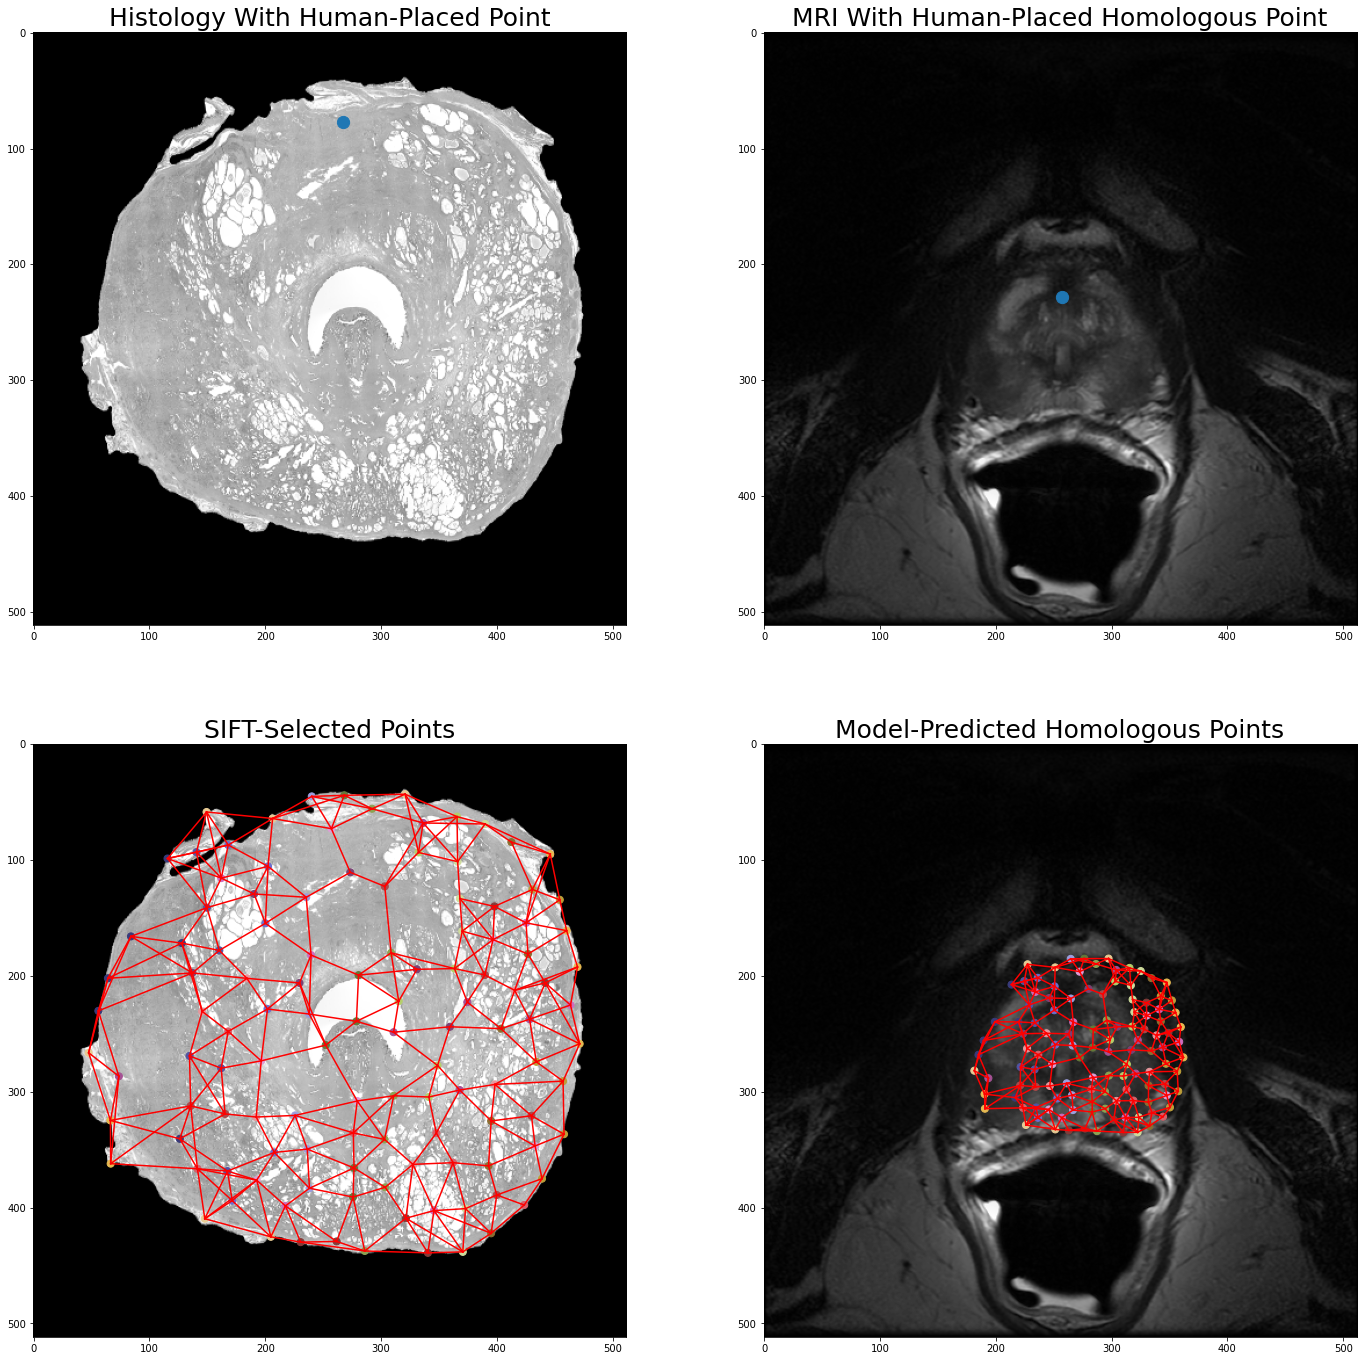

In [6]:
fig, subfigs = plt.subplots(nrows=2, ncols=2, figsize=(24, 24))
import matplotlib.cm as cm
colormap = cm.tab20b(np.linspace(0, 1, len(input_points)))

# HIST Single Point
subfigs[0][0].imshow(hist, cmap="gray")
subfigs[0][0].scatter([hist_point[1]], [hist_point[0]], s=150)
subfigs[0][0].set_title("Histology With Human-Placed Point", size=25)
# MRI Single Point
subfigs[0][1].imshow(mri * 2, cmap="gray")
subfigs[0][1].scatter([mri_point[1]], [mri_point[0]], s=150)
subfigs[0][1].set_title("MRI With Human-Placed Homologous Point", size=25)
# Input Points
subfigs[1][0].imshow(hist, cmap="gray")
subfigs[1][0].scatter(input_points[:, 1], input_points[:, 0], s=50, c=colormap)
neighbor_pairs = get_adj(input_points, num_neighbors=5)
plot_web(subfigs[1][0], input_points, neighbor_pairs)
subfigs[1][0].set_title("SIFT-Selected Points", size=25)

# Output Points
subfigs[1][1].imshow(mri, cmap="gray")
subfigs[1][1].scatter(output_points[:, 1], output_points[:, 0], s=50, c=colormap)
plot_web(subfigs[1][1], output_points, neighbor_pairs)
subfigs[1][1].set_title("Model-Predicted Homologous Points", size=25)

plt.show()

In [7]:
transformed = warp_image(dimension_reduce(hist), input_points, output_points)

In [8]:
human_hist_points = np.load(os.path.join(slide_dir, "hist_points.npy"))
human_mri_points = np.load(os.path.join(slide_dir, "mri_points.npy"))
transformed_human = warp_image(dimension_reduce(hist), human_hist_points, human_mri_points)

In [9]:
equalized = cv2.equalizeHist(dimension_reduce(mri * 255).astype(np.uint8))

Text(0.5, 1.0, 'Transformed with Network-Placed Points')

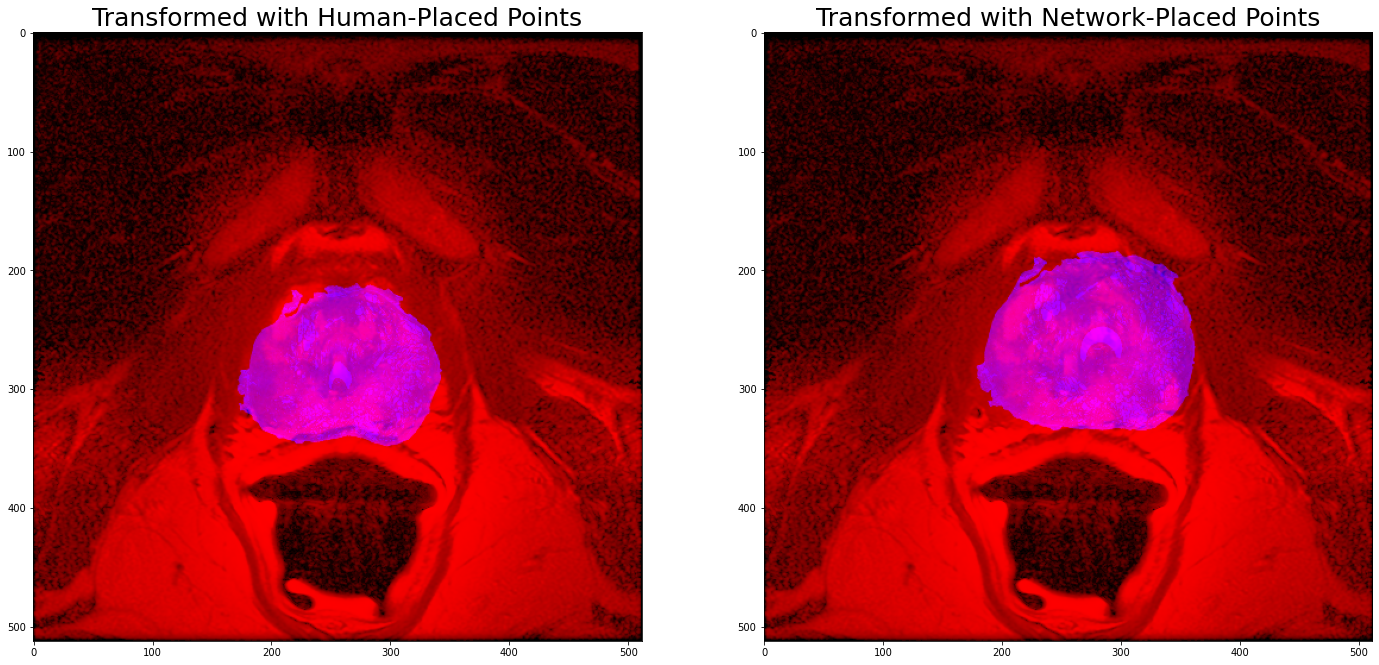

In [10]:
overlay_bot = np.stack((equalized / 255.0, np.zeros((512, 512)), dimension_reduce(transformed)), axis=-1)
overlay_human = np.stack((equalized / 255.0, np.zeros((512, 512)), dimension_reduce(transformed_human)), axis=-1)

fig, subfigs = plt.subplots(nrows=1, ncols=2, figsize=(24, 24))
# Human Solve
subfigs[0].imshow(overlay_human)
subfigs[0].set_title("Transformed with Human-Placed Points", size=25)

# Our Solution Solve
subfigs[1].imshow(overlay_bot)
subfigs[1].set_title("Transformed with Network-Placed Points", size=25)

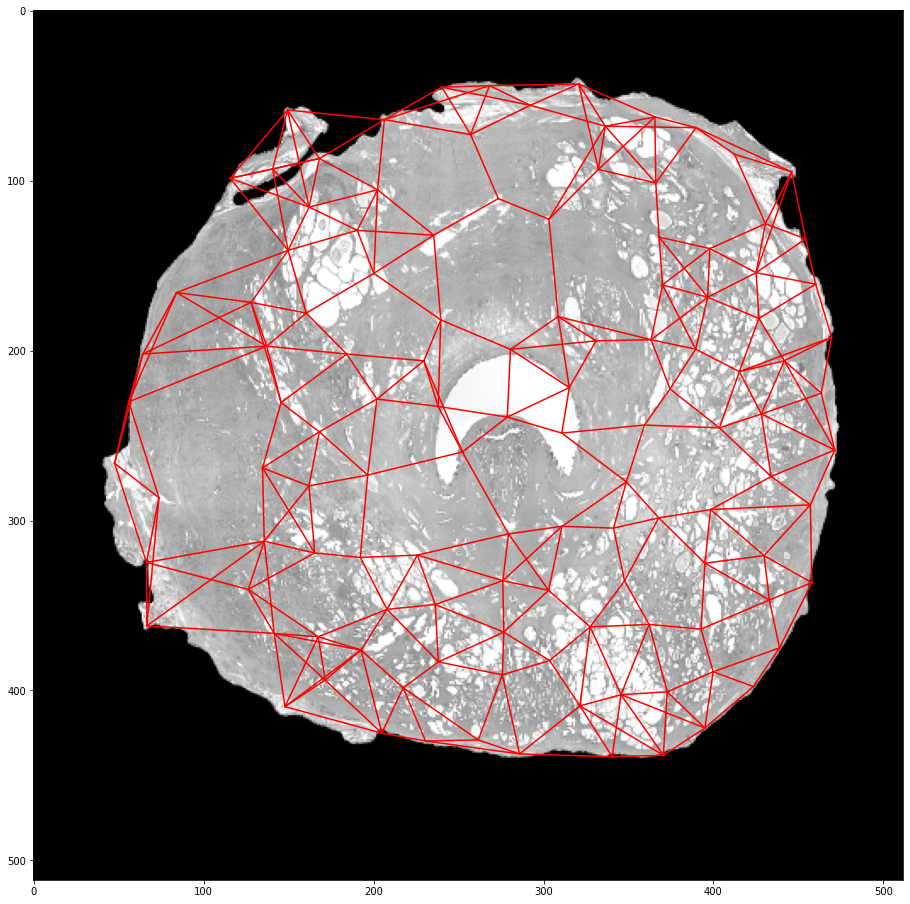

In [11]:
neighbor_pairs = get_adj(input_points, num_neighbors=5)
plt.figure(figsize=(16, 16))
plt.imshow(hist, cmap="gray")
plot_web(plt, input_points, neighbor_pairs)

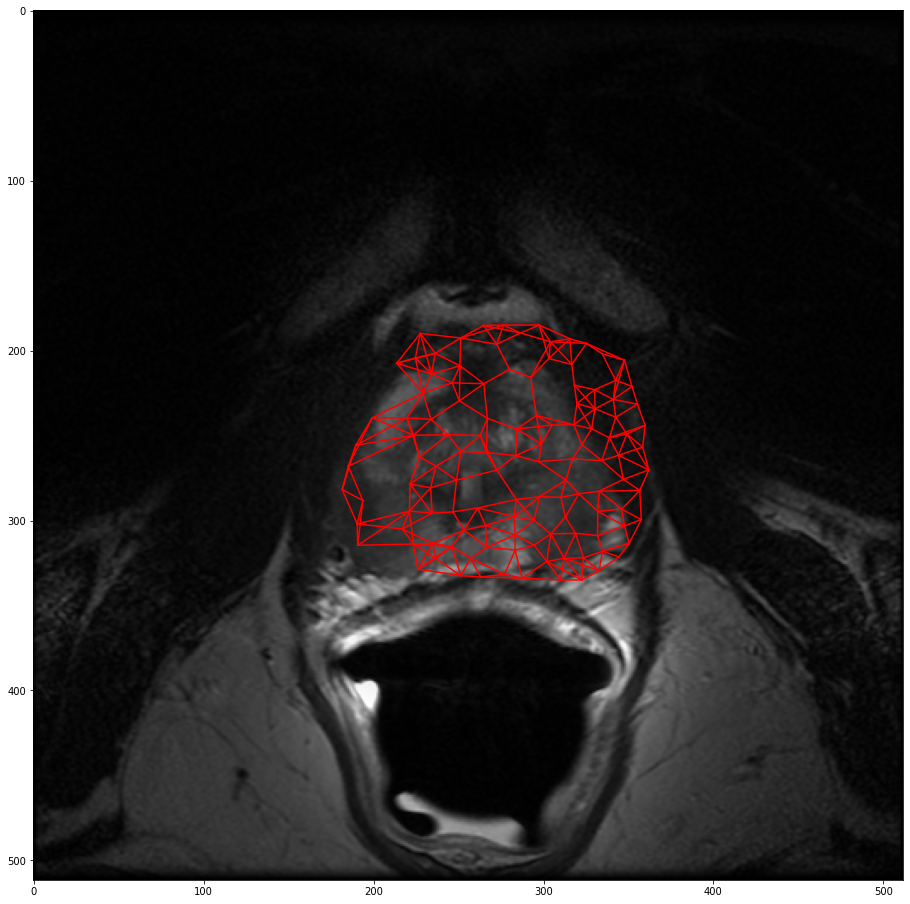

In [12]:
plt.figure(figsize=(16, 16))
plt.imshow(mri, cmap="gray")
plot_web(plt, output_points, neighbor_pairs)

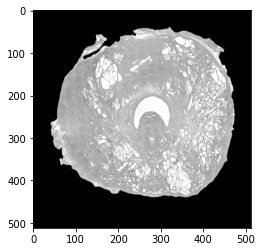

In [13]:
plt.imshow(hist, cmap="gray")

## Mean Control Point Deviaton

In [18]:
slide_dir = "../data/1110/7"
mri = np.load(os.path.join(slide_dir, "moving.npy"))
hist = np.load(os.path.join(slide_dir, "fixed.npy"))
mri_points = np.load(os.path.join(slide_dir, "mri_points.npy"))
hist_points = np.load(os.path.join(slide_dir, "hist_points.npy"))
hist_point = np.load(os.path.join(slide_dir, "point_0", "fixed_point.npy"))
mri_point = np.load(os.path.join(slide_dir, "point_0", "moving_point.npy"))

In [29]:
model = load_model("../outputs/01-16-22|18:01:23/model")
#input_points = np.array(compute_points(hist * 255, dist_thresh=25))
#input_points = filter_points(input_points, hist)
output_points = model.predict([np.repeat([hist], len(hist_points), axis=0), np.repeat([mri], len(hist_points), axis=0), hist_points])

Text(0.5, 1.0, 'Human Placed')

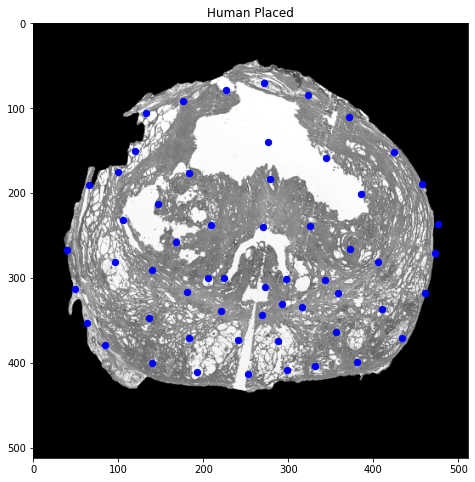

In [25]:
neighbor_pairs = get_adj(input_points, num_neighbors=5)
plt.figure(figsize=(8, 8))
plt.imshow(hist, cmap="gray")
plt.scatter(hist_points[:, 1], hist_points[:, 0], c="blue", s=40)
plt.title("Human Placed")

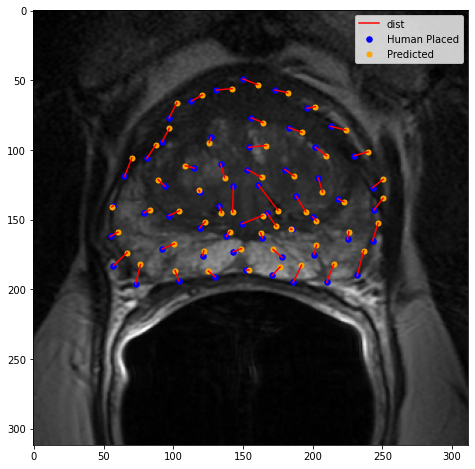

In [45]:
plt.figure(figsize=(8, 8))
plt.imshow(mri[100:-100, 100:-100], cmap="gray")
for i in range(len(output_points)):
    plt.plot([output_points[i, 1] - 120, mri_points[i, 1]-100], [output_points[i, 0]-100, mri_points[i, 0]-100], c="red", label="dist")
plt.scatter(mri_points[:, 1]-100, mri_points[:, 0]-100, c="blue", s=30, label="Human Placed")
plt.scatter(output_points[:, 1] - 120, output_points[:, 0]-100, c="orange", s=25, label="Predicted")
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())